In [20]:
from backdoors import data, patterns, poison, utils
from backdoors.data import load_cifar10, Data
import numpy as np
import matplotlib.pyplot as plt
import einops
import jax
from jax import numpy as jnp
from flax.training import train_state
import optax
import chex
import flax
from backdoors.models import CNN
from flax import linen as nn
from backdoors.train import TrainState, Metrics, train, model, tx, \
    accuracy, train_step, init_train_state
from typing import Tuple
import matplotlib.pyplot as plt
import sympy
from jax import random
from collections import namedtuple
from time import time
rng = random.PRNGKey(0)



train_data, _ = load_cifar10()

def init(rng):
    params = model.init(rng, jnp.ones((1, 32, 32, 3)))['params']
    opt_state = tx.init(params)
    return TrainState(params=params, opt_state=opt_state)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
NUM_EPOCHS = 1

def get_single_train_fn(batch_size):
    batches = data.batch_data(train_data, batch_size)

    @jax.jit
    def t(state):
        return train(state, batches, test_data=None, num_epochs=NUM_EPOCHS)
    
    state = init(rng)
    _ = t(state)
    return t


def get_train_fns(batch_size, num_models):
    batches = data.batch_data(train_data, batch_size)


    @jax.jit
    def t(state):
        return train(state, batches, test_data=None, num_epochs=NUM_EPOCHS)


    @jax.jit
    def train_batched(states):
        return jax.vmap(t)(states)
    

    # init NUM_MODELS models
    subkeys = jax.random.split(rng, num_models)
    states = jax.vmap(init)(subkeys)
    states_list = [init(subkey) for subkey in subkeys]

    # compile
    _ = train_batched(states)
    _ = t(states_list[0])
    return t, train_batched

In [3]:
train_single, train_batched = get_train_fns(batch_size=32, num_models=2)

### just compare different batch sizes (single model)

In [36]:
def get_time_single(bs):
    state = init(rng)
    batches = data.batch_data(train_data, bs)
    _ = train(state, batches, num_epochs=1)  # run once to compile
    start = time()
    _, (m, _) = train(state, batches, num_epochs=1)
    m.loss.block_until_ready()
    end = time()
    return end - start

In [39]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
times = [get_time_single(bs) for bs in batch_sizes]

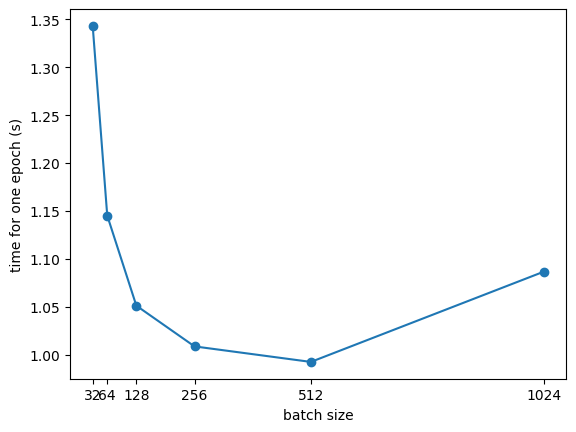

In [45]:
plt.plot(batch_sizes, times, 'o-')
plt.xlabel('batch size')
plt.ylabel('time for one epoch (s)')
plt.xticks(batch_sizes);

### compare different num_models and batch sizes

In [ ]:
subkey, rng = random.split(rng)

@flax.struct.dataclass
class Times:
    batched: float
    linear: float


def get_times(train_single, train_batched, num_models):
    # init NUM_MODELS models
    subkeys = jax.random.split(rng, num_models)
    states = jax.vmap(init)(subkeys)
    states_list = [init(subkey) for subkey in subkeys]


    # batched
    t0 = time()
    _, (train_metrics, _) = train_batched(states)
    train_metrics.loss.block_until_ready()
    total_batched = time() - t0


    # linear:
    t0 = time()
    outputs = [train_single(s) for s in states_list]
    for o in outputs:
        _, (mt, _) = o
        mt.loss.block_until_ready()
    total_linear = time() - t0
    return Times(total_batched / num_models, total_linear  / num_models)

In [5]:
times = {}
for bs in [8, 16, 32]:
    num_models = [1, 16, 64*16//bs]
    times[bs] = [get_times(*get_train_fns(bs, n), n) for n in num_models]

Text(0.5, 0, 'number of models')

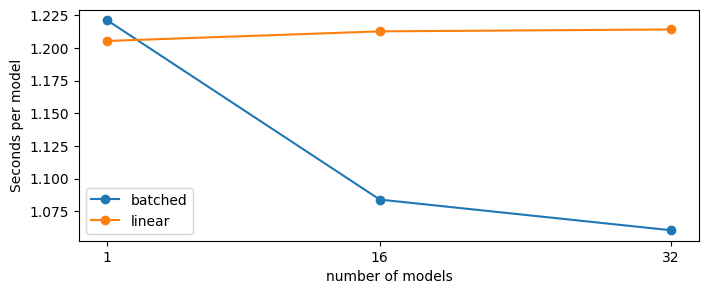

In [14]:
def plot_times(times_list, *args, **kwargs):
    plt.plot(num_models, [t.batched for t in times_list], "o-", *args, label="batched", **kwargs)
    plt.plot(num_models, [t.linear for t in times_list], "o-", *args, label="linear", **kwargs)

bs = 32
num_models = [1, 16, 64*16//bs]
plt.figure(figsize=(8, 3))
plot_times(times[bs])
plt.legend()
plt.xticks(num_models)
plt.ylabel("Seconds per model")
plt.xlabel("number of models")

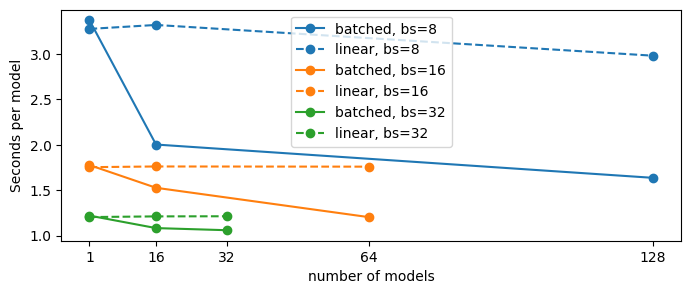

In [27]:
plt.figure(figsize=(8, 3))
for bs in [8, 16, 32]:
    num_models = [1, 16, 64*16//bs]
    l = plt.plot(num_models, [t.batched for t in times[bs]], "o-", label=f"batched, bs={bs}")
    plt.plot(num_models, [t.linear for t in times[bs]], "o--", label=f"linear, bs={bs}", color=l[0].get_color())
    plt.legend()
    plt.xticks([1, 16, 32, 64, 128])
    plt.ylabel("Seconds per model")
    plt.xlabel("number of models")